This notebook contains Helen's python code for loading and getting counts of the DC Inbox newletter content files.

In [548]:
# KEEP
# import libraries
import pandas as pd
# import numpy as np
# import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# set default seaborn theme
# sns.reset_defaults()
# sns.set_theme()


In [509]:
# Read in the joined all dataset

joined_all_df = pd.read_csv(
#     "../data/dcinbox/dcinbox_export_119th_through9_19_2025.csv",
    "../data/matched/joined_all_2020_test.csv",
    # sep = ",",            # columns are separated by commas
    encoding = "latin1",
    quotechar = '"',   # Make sure actual quotation marks in newsletters are handled right
    engine = 'python'    # This might be able to handle very long messages better,
    # names = column_names
)

# Remove all unnamed columns, because they're messing up the read of the file
# unnamed = dcinbox_raw_df.columns.str.contains('^Unnamed')
# dcinbox_clean_columns_df = dcinbox_raw_df.loc[:, ~unnamed]
# dcinbox_clean_columns_df = dcinbox_raw_df.loc[:, ~unnamed].copy()

# Limit to the date range we want
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])
joined_all_df = joined_all_df[joined_all_df["dc_date"].between("2019-11-03","2020-11-02")]

print(len(joined_all_df))
joined_all_df.head()
# joined_all_df.columns

15589


,dc_name,dc_date,newsletter_count,body_word_count_sum,total_newsletters_x,dc_congress,dc_gender,dc_state,dc_district,dc_chamber,...,contrib_amount,Unnamed: 18,avg_daily_contrib_count,avg_daily_contrib_amount,total_newsletters_y,window_days,window_contrib_count,window_contrib_amount,contrib_count_score,contrib_amount_score
21,A. FERGUSON,2019-11-06,1,590,44,116,M,GA,3,House,...,1000.0,1602.335484,1,678.58,44.0,3,1,1000.0,0.22,0.49
22,A. FERGUSON,2019-11-13,1,874,44,116,M,GA,3,House,...,0.0,NaN,0,0.00,NaN,0,0,0.0,0.00,0.00
23,A. FERGUSON,2019-11-20,1,1118,44,116,M,GA,3,House,...,0.0,NaN,0,0.00,NaN,0,0,0.0,0.00,0.00
24,A. FERGUSON,2019-12-04,1,712,44,116,M,GA,3,House,...,0.0,NaN,0,0.00,NaN,0,0,0.0,0.00,0.00
25,A. FERGUSON,2019-12-11,1,1117,44,116,M,GA,3,House,...,0.0,NaN,0,0.00,NaN,0,0,0.0,0.00,0.00


In [510]:
# Read in the summarized FEC candidate contributions file

# column_names = ["target_id", "dcinbox_name", "fec_cid", "fec_name",
#                 "fec_party", "fec_state", "fec_district",
#                 "fec_cycle", "append_attribute2", "append_attribute3",
#                 "similarity_score", "matched_scorer"]

cand_contribs_raw_df = pd.read_csv(
    "../data/fec/candidate_contributions_2020_test.csv",
    encoding = "latin1",
    # quotechar = '"',   # Make sure actual quotation marks are handled right
    # names = column_names,
    # header = 0
)

# Drop the columns we don't need
cand_contribs_raw_df = cand_contribs_raw_df.drop(columns=['DistIDRunFor', 'DistIDCurr', "CurrCand", "CycleCand", 
                                                  "RecipCode", "CRPICO", "FECCandID"])

print(len(cand_contribs_raw_df))
cand_contribs_raw_df.head()

85572


,Cycle,CID,FirstLastP,Party Original,NoPacs,State,District,Party,contrib_date,contrib_count,contrib_amount,Unnamed: 18
0,2020,N00030910,MO BROOKS,R,,AL,5,R,11/11/2019,2,2750,NaN
1,2020,N00030910,MO BROOKS,R,,AL,5,R,12/23/2019,1,2800,NaN
2,2020,N00030910,MO BROOKS,R,,AL,5,R,1/6/2020,1,100,NaN
3,2020,N00030910,MO BROOKS,R,,AL,5,R,1/15/2020,1,250,NaN
4,2020,N00030910,MO BROOKS,R,,AL,5,R,1/17/2020,6,9000,NaN


In [511]:
# Clean up columns in the summarized FEC candidate contributions dataframe

# Rename columns so they won't clash with the DC Inbox data file
cand_contribs_raw_df = cand_contribs_raw_df.rename(columns={
    "Cycle": "fec_cycle",
    "CID": "fec_cid",
    "FirstLastP": "fec_name",
    "Party Original": "fec_party_original",
    "NoPacs": "no_pacs",
    "State": "fec_state",
    "District": "fec_district",
    "Party": "fec_party"    
})

# Set correct types on some columns
# cand_contribs_df["contrib_amount"] = cand_contribs_df["contrib_amount"].fillna(0).astype(int)
# cand_contribs_window_df["window_contrib_amount_sum"] = cand_contribs_window_df["window_contrib_amount_sum"].fillna(0).astype(int)
# cand_contribs_window_df["window_contrib_count_sum"] = cand_contribs_window_df["window_contrib_count_sum"].fillna(0).astype(int)
cand_contribs_raw_df["contrib_count"] = cand_contribs_raw_df["contrib_count"].fillna(0)
cand_contribs_raw_df["contrib_amount"] = cand_contribs_raw_df["contrib_amount"].fillna(0).astype(int)

# Define date range for averaging
start_date = pd.Timestamp("2019-11-03")
end_date = pd.Timestamp("2020-11-02")

# Make sure contrib_date is datetime
cand_contribs_raw_df["contrib_date"] = pd.to_datetime(cand_contribs_raw_df["contrib_date"])

# Filter to the target period
mask = (cand_contribs_raw_df["contrib_date"] >= start_date) & (cand_contribs_raw_df["contrib_date"] <= end_date)
filtered = cand_contribs_raw_df.loc[mask].copy()

# Compute average daily contribution count and amount for each candidate
avg_stats = (
    filtered.groupby(["fec_name", "fec_cycle", "fec_state", "fec_district", "fec_party"], dropna=False)
    .agg(
        avg_daily_contrib_count=("contrib_count", "mean"),
        avg_daily_contrib_amount=("contrib_amount", "mean")
    )
    .reset_index()
)

# Merge those averages back into the main dataframe
cand_contribs_df = cand_contribs_raw_df.merge(
    avg_stats,
    on=["fec_name", "fec_cycle", "fec_state", "fec_district", "fec_party"],
    how="left"
)

# Fill any missing averages with 0 (e.g., if outside range)
cand_contribs_df["avg_daily_contrib_count"] = cand_contribs_df["avg_daily_contrib_count"].fillna(0)
cand_contribs_df["avg_daily_contrib_amount"] = cand_contribs_df["avg_daily_contrib_amount"].fillna(0)

cand_contribs_df.head()

,fec_cycle,fec_cid,fec_name,fec_party_original,no_pacs,fec_state,fec_district,fec_party,contrib_date,contrib_count,contrib_amount,Unnamed: 18,avg_daily_contrib_count,avg_daily_contrib_amount
0,2020,N00030910,MO BROOKS,R,,AL,5,R,2019-11-11,2,2750,NaN,1.321429,1440.214286
1,2020,N00030910,MO BROOKS,R,,AL,5,R,2019-12-23,1,2800,NaN,1.321429,1440.214286
2,2020,N00030910,MO BROOKS,R,,AL,5,R,2020-01-06,1,100,NaN,1.321429,1440.214286
3,2020,N00030910,MO BROOKS,R,,AL,5,R,2020-01-15,1,250,NaN,1.321429,1440.214286
4,2020,N00030910,MO BROOKS,R,,AL,5,R,2020-01-17,6,9000,NaN,1.321429,1440.214286


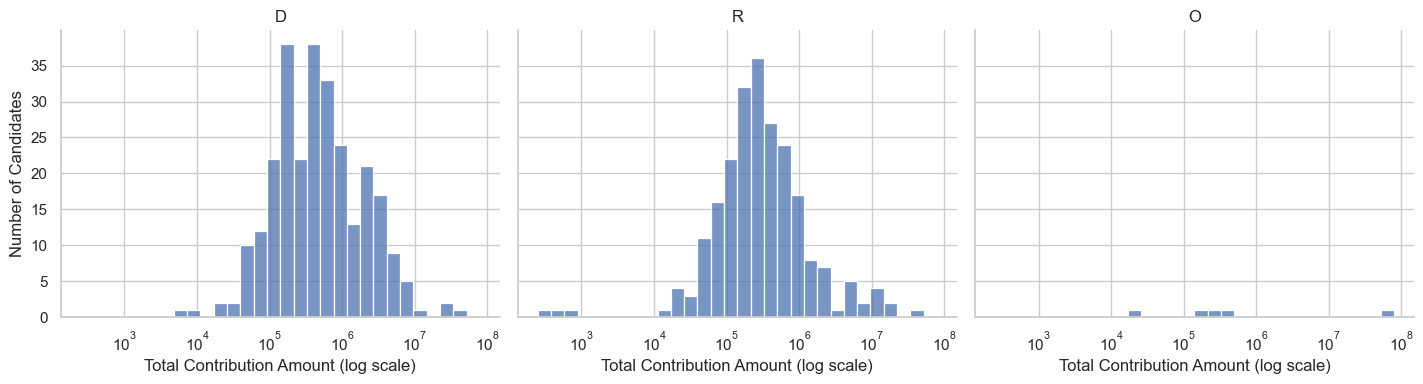

In [512]:
# Distribution of total contributions by party

# Aggregate to total contributions per politician
agg_df = (
    cand_contribs_df
    .groupby(["fec_cid", "fec_party"], as_index=False)
    ["contrib_amount"].sum()
)

# Plot faceted histograms (log-scaled)
sns.set(style="whitegrid")

g = sns.displot(
    data=agg_df,
    x="contrib_amount",
    col="fec_party",
    bins=30,
    col_wrap=3,
    height=4,
    aspect=1.2,
    log_scale=True,   # <-- log the x-axis directly
    color=None
)

# Add titles and axis labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Total Contribution Amount (log scale)", "Number of Candidates")

plt.tight_layout()
plt.show()


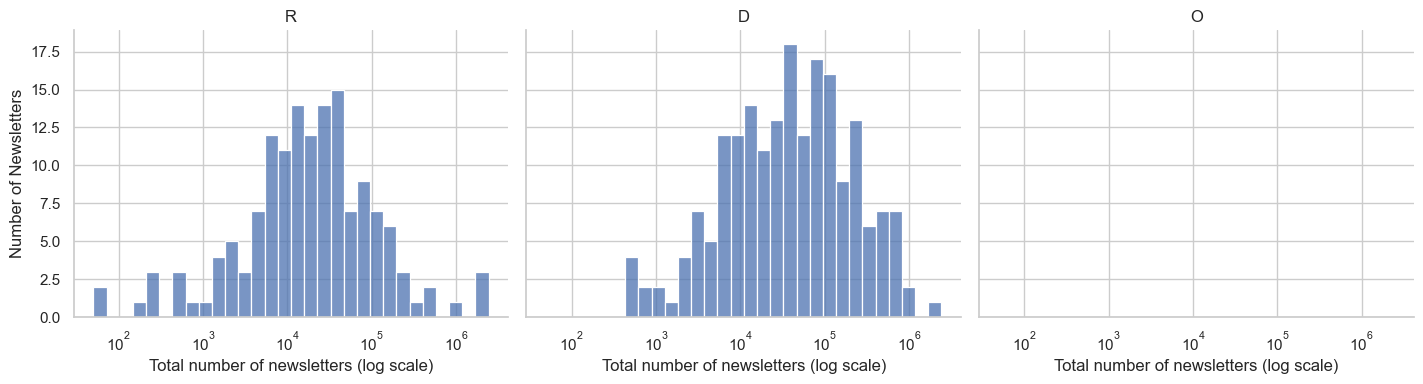

In [513]:
# Distribution of total newsletters by party

# Aggregate to total newsletters per politician
agg_df = (
    joined_all_df
    .groupby(["dc_name", "dc_party"], as_index=False)
    ["contrib_amount"].sum()
)

# Plot faceted histograms (log-scaled)
sns.set(style="whitegrid")

g = sns.displot(
    data=agg_df,
    x="contrib_amount",
    col="dc_party",
    bins=30,
    col_wrap=3,
    height=4,
    aspect=1.2,
    log_scale=True,   # <-- log the x-axis directly
    color=None
)

# Add titles and axis labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Total number of newsletters (log scale)", "Number of Newsletters")

plt.tight_layout()
plt.show()


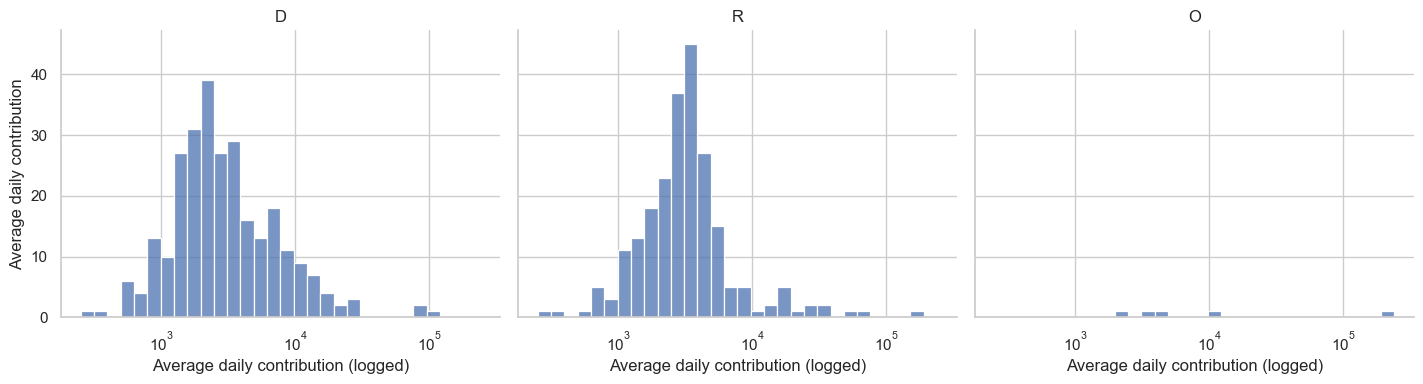

In [514]:
# Distribution of average daily contribution by party

# Aggregate average daily contribution per politician
agg_df = (
    cand_contribs_df
    .groupby(["fec_cid", "fec_party"], as_index=False)
    ["avg_daily_contrib_amount"].mean()
)

# Plot faceted histograms (log-scaled)
sns.set(style="whitegrid")

g = sns.displot(
    data=agg_df,
    x="avg_daily_contrib_amount",
    col="fec_party",
    bins=30,
    col_wrap=3,
    height=4,
    aspect=1.2,
    log_scale=True,   # <-- log the x-axis directly
    color=None
)

# Add titles and axis labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average daily contribution (logged)", "Average daily contribution")

plt.tight_layout()
plt.show()


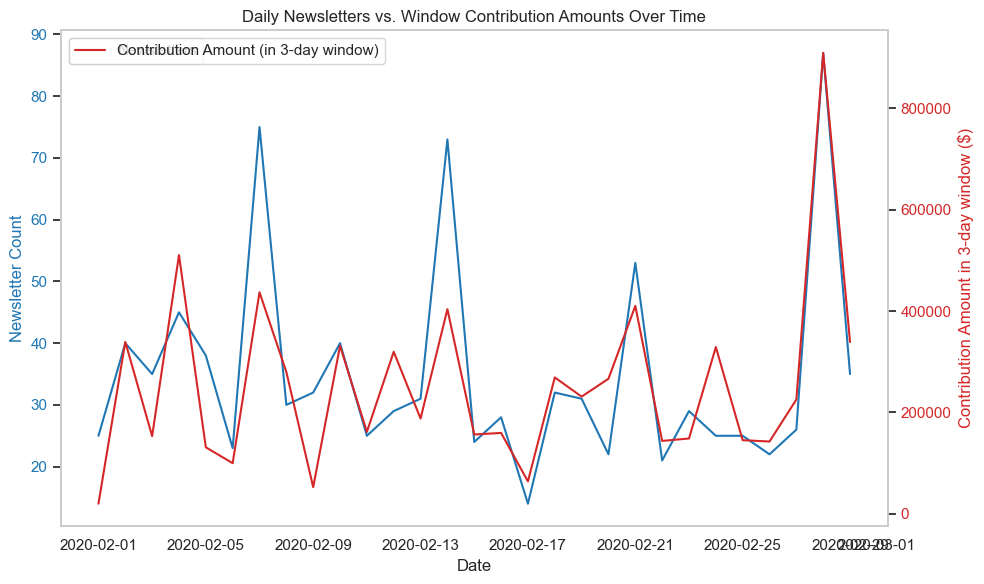

In [515]:
# Make sure dates are in datetime format
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])

# Limit to one month
joined_date_filter_df = joined_all_df[joined_all_df["dc_date"].between("2020-02-01", "2020-02-29")]

# Group by day (if multiple rows per date)
daily_df = (
    joined_date_filter_df
    .groupby("dc_date", as_index=False)
    .agg({
        "newsletter_count": "sum",
        "window_contrib_amount": "sum"
    })
    .sort_values("dc_date")
)

# --- Create line plot with dual y-axes ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot newsletter count (left axis)
sns.lineplot(
    data=daily_df,
    x="dc_date",
    y="newsletter_count",
    ax=ax1,
    color="tab:blue",
    label="Newsletters"
)
ax1.set_ylabel("Newsletter Count", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Create second y-axis for contribution amounts
ax2 = ax1.twinx()
sns.lineplot(
    data=daily_df,
    x="dc_date",
    y="window_contrib_amount",
    ax=ax2,
    color="tab:red",
    label="Contribution Amount (in 3-day window)"
)
ax2.set_ylabel("Contribution Amount in 3-day window ($)", color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

# Labels, titles, and cleanup
ax1.set_xlabel("Date")
plt.title("Daily Newsletters vs. Window Contribution Amounts Over Time")
plt.xticks(rotation=90)

# Remove gridlines
ax1.grid(False)
ax2.grid(False)

fig.tight_layout()
plt.show()


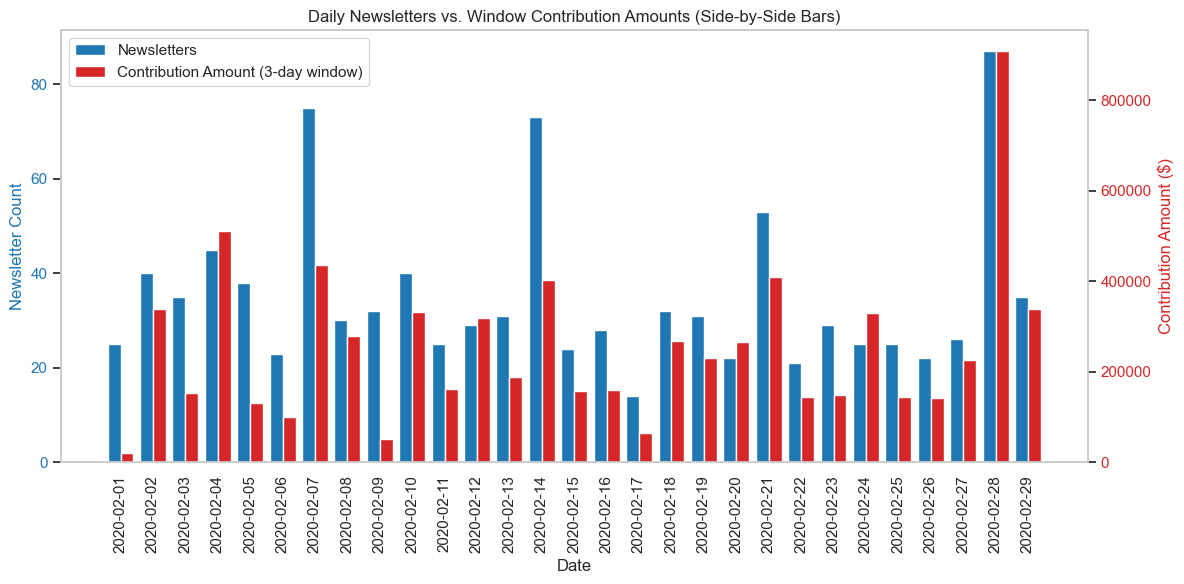

In [516]:
# Make sure dates are in datetime format
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])

# Limit to one month
joined_date_filter_df = joined_all_df[joined_all_df["dc_date"].between("2020-02-01", "2020-02-29")]

# Group by day
daily_df = (
    joined_date_filter_df
    .groupby("dc_date", as_index=False)
    .agg({
        "newsletter_count": "sum",
        "window_contrib_amount": "sum"
    })
    .sort_values("dc_date")
)

# --- Create side-by-side bar chart with twin y-axes ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create bar positions
x = np.arange(len(daily_df))
width = 0.4  # bar width

# Bars for newsletter count (left axis)
ax1.bar(
    x - width/2,
    daily_df["newsletter_count"],
    width=width,
    color="tab:blue",
    label="Newsletters"
)
ax1.set_ylabel("Newsletter Count", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Bars for contribution amount (right axis)
ax2 = ax1.twinx()
ax2.bar(
    x + width/2,
    daily_df["window_contrib_amount"],
    width=width,
    color="tab:red",
    label="Contribution Amount (3-day window)"
)
ax2.set_ylabel("Contribution Amount ($)", color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

# --- X-axis formatting ---
ax1.set_xlabel("Date")
ax1.set_xticks(x)
ax1.set_xticklabels(daily_df["dc_date"].dt.strftime("%Y-%m-%d"), rotation=90)

# --- Title and cleanup ---
plt.title("Daily Newsletters vs. Window Contribution Amounts (Side-by-Side Bars)")
ax1.grid(False)
ax2.grid(False)

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left")

fig.tight_layout()
plt.show()

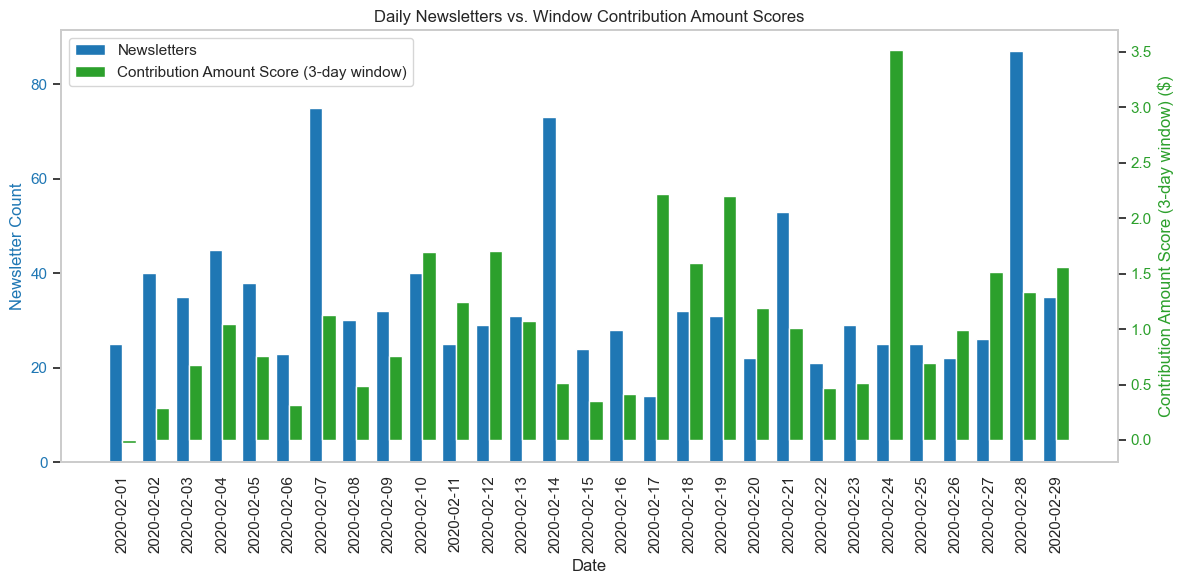

In [517]:
# Make sure dates are in datetime format
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])

# Limit to one month
joined_date_filter_df = joined_all_df[joined_all_df["dc_date"].between("2020-02-01", "2020-02-29")]

# Group by day
daily_df = (
    joined_date_filter_df
    .groupby("dc_date", as_index=False)
    .agg({
        "newsletter_count": "sum",   # still sum newsletters per day
        "contrib_amount_score": "mean"  # now take the daily average
    })
    .sort_values("dc_date")
)

# --- Create side-by-side bar chart with twin y-axes ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create bar positions
x = np.arange(len(daily_df))
width = 0.4  # bar width

# Bars for newsletter count (left axis)
ax1.bar(
    x - width/2,
    daily_df["newsletter_count"],
    width=width,
    color="tab:blue",
    label="Newsletters"
)
ax1.set_ylabel("Newsletter Count", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Bars for contribution amount (right axis)
ax2 = ax1.twinx()
ax2.bar(
    x + width/2,
    daily_df["contrib_amount_score"],
    width=width,
    color="tab:green",
    label="Contribution Amount Score (3-day window)"
)
ax2.set_ylabel("Contribution Amount Score (3-day window) ($)", color="tab:green")
ax2.tick_params(axis='y', labelcolor="tab:green")

# --- X-axis formatting ---
ax1.set_xlabel("Date")
ax1.set_xticks(x)
ax1.set_xticklabels(daily_df["dc_date"].dt.strftime("%Y-%m-%d"), rotation=90)

# --- Title and cleanup ---
plt.title("Daily Newsletters vs. Window Contribution Amount Scores")
ax1.grid(False)
ax2.grid(False)

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left")

fig.tight_layout()
plt.show()

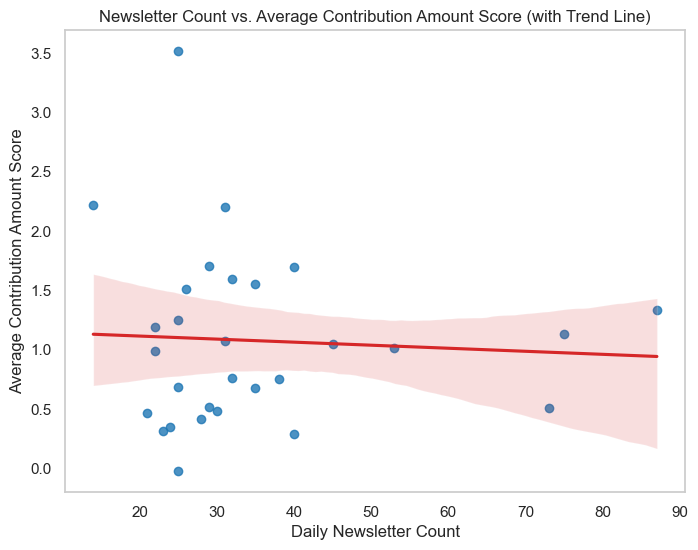

In [518]:
# Make sure dates are in datetime format
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])

# Limit to one month
joined_date_filter_df = joined_all_df[joined_all_df["dc_date"].between("2020-02-01", "2020-02-29")]

# Group by day
daily_df = (
    joined_date_filter_df
    .groupby("dc_date", as_index=False)
    .agg({
        "newsletter_count": "sum",   # still sum newsletters per day
        "contrib_amount_score": "mean"  # now take the daily average
    })
    .sort_values("dc_date")
)

plt.figure(figsize=(8, 6))
sns.regplot(
    data=daily_df,
    x="newsletter_count",
    y="contrib_amount_score",
    scatter_kws={"color": "tab:blue"},
    line_kws={"color": "tab:red"}
)
plt.title("Newsletter Count vs. Average Contribution Amount Score (with Trend Line)")
plt.xlabel("Daily Newsletter Count")
plt.ylabel("Average Contribution Amount Score")
plt.grid(False)
plt.show()


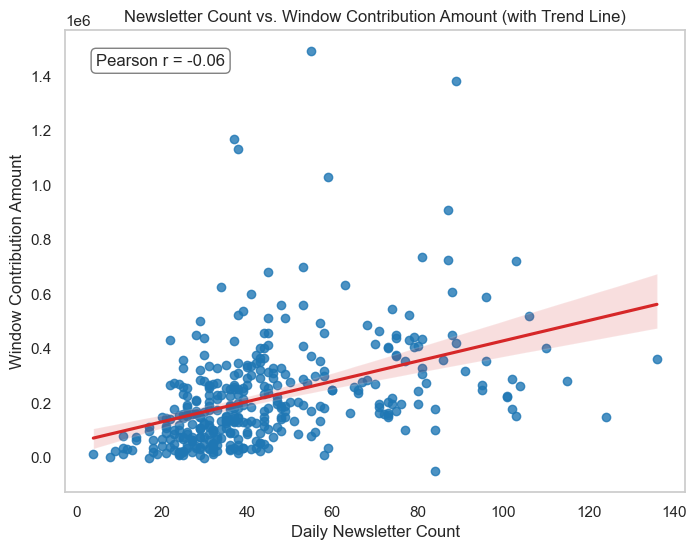

In [519]:
# Make sure dates are in datetime format
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])

# Limit to one month
joined_date_filter_df = joined_all_df[joined_all_df["dc_date"].between("2019-11-03", "2020-11-02")]

# Calculate correlation
corr = daily_df["newsletter_count"].corr(daily_df["contrib_amount_score"])

# Group by day
daily_df = (
    joined_date_filter_df
    .groupby("dc_date", as_index=False)
    .agg({
        "newsletter_count": "sum",   # still sum newsletters per day
        "window_contrib_amount": "sum" 
    })
    .sort_values("dc_date")
)

plt.figure(figsize=(8, 6))
sns.regplot(
    data=daily_df,
    x="newsletter_count",
    y="window_contrib_amount",
    scatter_kws={"color": "tab:blue"},
    line_kws={"color": "tab:red"}
)

# Add correlation annotation
plt.text(
    0.05, 0.95,  # x and y as fractions of the axes (0-1)
    f"Pearson r = {corr:.2f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
)

plt.title("Newsletter Count vs. Window Contribution Amount (with Trend Line)")
plt.xlabel("Daily Newsletter Count")
plt.ylabel("Window Contribution Amount")
plt.grid(False)
plt.show()


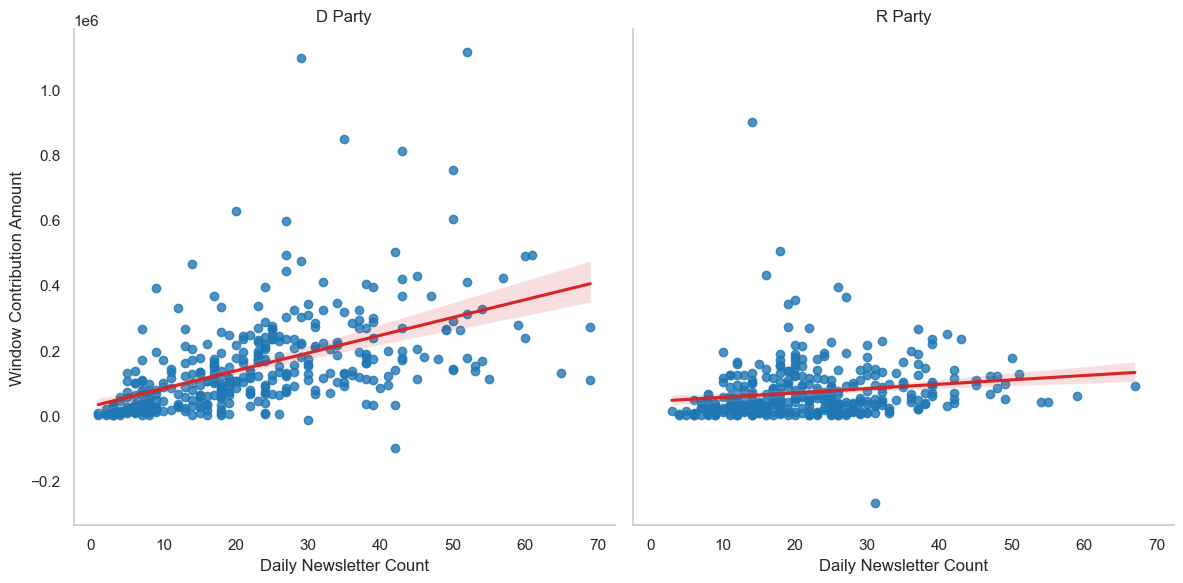

In [520]:
# Make sure dates are datetime
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])

# Filter dataframe
joined_date_filter_df = joined_all_df[joined_all_df["dc_date"].between("2019-11-03", "2020-11-02")]
joined_date_filter_df = joined_date_filter_df[joined_date_filter_df["dc_party"].isin(["D", "R"])]

# Group by day and party
daily_party_df = (
    joined_date_filter_df
    .groupby(["dc_date", "dc_party"], as_index=False)
    .agg({
        "newsletter_count": "sum",
        "window_contrib_amount": "sum"
    })
    .sort_values(["dc_party", "dc_date"])
)

# Create FacetGrid for party
g = sns.FacetGrid(daily_party_df, col="dc_party", height=6, aspect=1)
g.map_dataframe(
    sns.regplot,
    x="newsletter_count",
    y="window_contrib_amount",
    scatter_kws={"color": "tab:blue"},
    line_kws={"color": "tab:red"}
)

# Add titles and labels
g.set_axis_labels("Daily Newsletter Count", "Window Contribution Amount")
g.set_titles(col_template="{col_name} Party")

# Optional: remove gridlines
for ax in g.axes.flat:
    ax.grid(False)

plt.tight_layout()
plt.show()


c:\Users\hefla\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\hefla\AppData\Local\Temp\ipykernel_19392\805539306.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_values = agg_df.groupby("dc_party").apply(


Pearson r per party:
 dc_party
D    0.527096
R    0.473771
dtype: float64


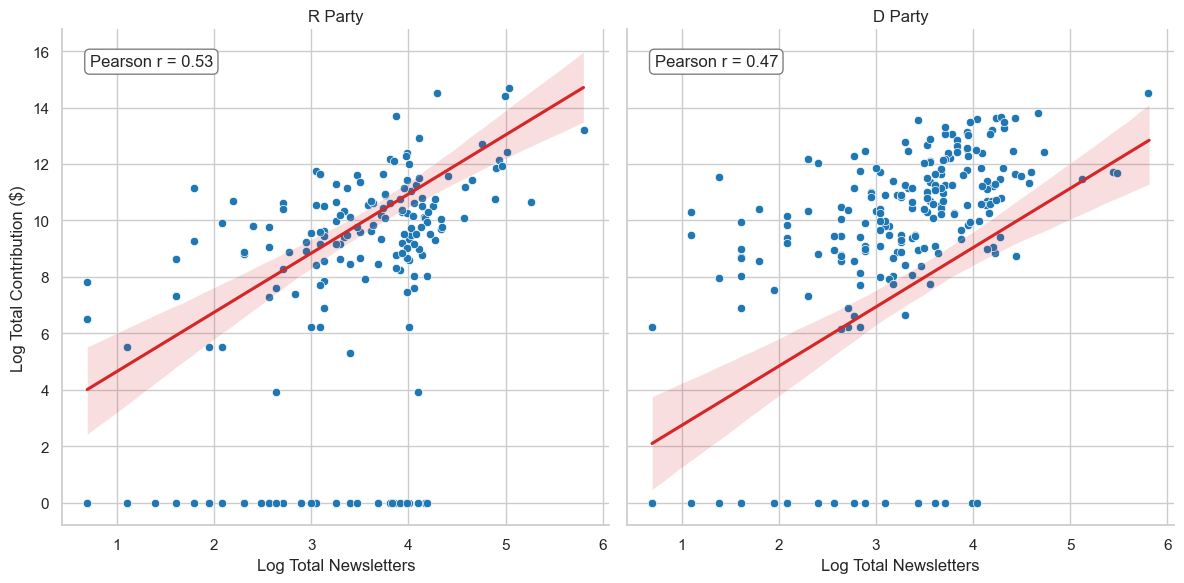

In [521]:
# Aggregate by candidate and party
agg_df = (
    joined_all_df[joined_all_df["dc_party"].isin(["D", "R"])]
    .groupby(["dc_name", "dc_party"], as_index=False)
    .agg({
        "newsletter_count": "sum",
        "contrib_amount": "sum"
    })
)

# Rename for clarity
agg_df = agg_df.rename(columns={
    "newsletter_count": "total_newsletters",
    "contrib_amount": "total_contrib"
})

# Log-transform both contributions and newsletters
agg_df["log_total_contrib"] = np.log1p(agg_df["total_contrib"])  # log(0+1) safe
agg_df["log_total_newsletters"] = np.log1p(agg_df["total_newsletters"])

# Compute Pearson r per party using pandas
r_values = agg_df.groupby("dc_party").apply(
    lambda df: df["log_total_newsletters"].corr(df["log_total_contrib"])
)

print("Pearson r per party:\n", r_values)

# --- Faceted scatterplot with log-transformed axes ---
g = sns.FacetGrid(agg_df, col="dc_party", height=6, aspect=1)
g.map_dataframe(
    sns.scatterplot,
    x="log_total_newsletters",
    y="log_total_contrib",
    color="tab:blue"
)

# Add regression line per facet
for ax, (party, r) in zip(g.axes.flat, r_values.items()):
    sns.regplot(
        data=agg_df[agg_df["dc_party"] == party],
        x="log_total_newsletters",
        y="log_total_contrib",
        scatter=False,
        ax=ax,
        color="tab:red"
    )
    # Annotate Pearson r
    ax.text(
        0.05, 0.95,
        f"Pearson r = {r:.2f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )

# Labels and titles
g.set_axis_labels("Log Total Newsletters", "Log Total Contribution ($)")
g.set_titles(col_template="{col_name} Party")
plt.tight_layout()
plt.show()


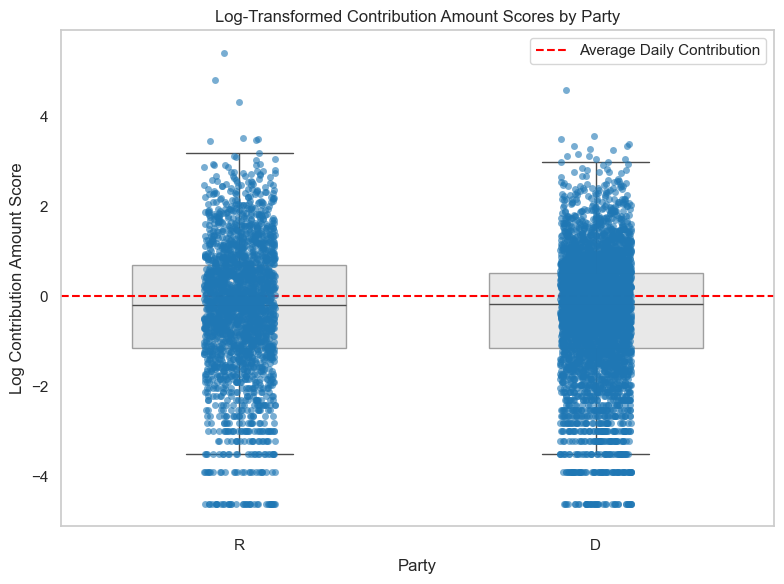

In [522]:
# Filter to only D and R, and positive contrib_amount_score for log
party_df = joined_all_df[
    (joined_all_df['dc_party'].isin(['D', 'R'])) &
    (joined_all_df['contrib_amount_score'] > 0)
].copy()

# Create a log-transformed column
party_df['log_contrib_score'] = np.log(party_df['contrib_amount_score'])

plt.figure(figsize=(8, 6))

# Boxplot for D vs R
sns.boxplot(
    data=party_df,
    x='dc_party',
    y='log_contrib_score',
    showcaps=True,
    boxprops={'facecolor':'lightgray', 'alpha':0.5},
    showfliers=False,
    whiskerprops={'linewidth':1},
    width=0.6
)

# Overlay individual points
sns.stripplot(
    data=party_df,
    x='dc_party',
    y='log_contrib_score',
    jitter=True,
    alpha=0.6,
    color='tab:blue'
)

# Add horizontal line at log(1) = 0 for average daily contribution
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='Average Daily Contribution')

plt.xlabel("Party")
plt.ylabel("Log Contribution Amount Score")
plt.title("Log-Transformed Contribution Amount Scores by Party")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

C:\Users\hefla\AppData\Local\Temp\ipykernel_19392\2633051289.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\hefla\AppData\Local\Temp\ipykernel_19392\2633051289.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


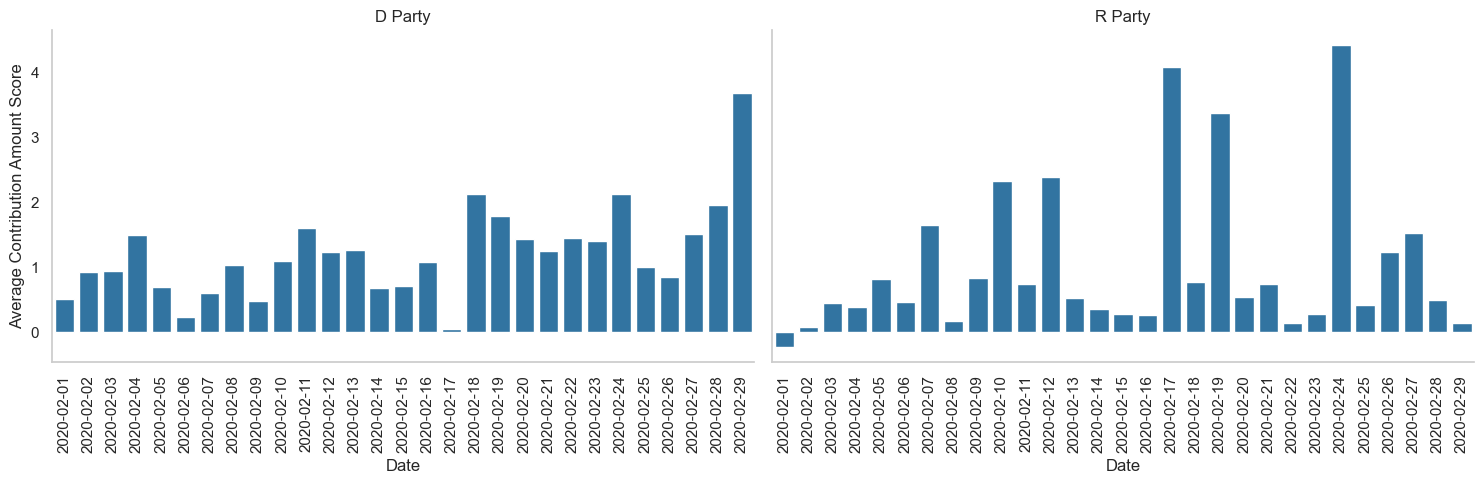

In [523]:
# Make sure dates are datetime
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])
joined_date_filter_df = joined_all_df[joined_all_df["dc_date"].between("2020-02-01","2020-02-29")]

# Filter to only D and R parties
party_df = joined_date_filter_df[joined_date_filter_df["dc_party"].isin(["D", "R"])].copy()

# Group by day and party to calculate average contribution amount score
daily_avg_df = (
    party_df.groupby(["dc_date", "dc_party"], as_index=False)
    .agg(avg_contrib_score=("contrib_amount_score", "mean"))
    .sort_values(["dc_party", "dc_date"])
)

# Create FacetGrid for party
g = sns.FacetGrid(daily_avg_df, col="dc_party", height=5, aspect=1.5)
g.map_dataframe(
    sns.barplot,
    x="dc_date",
    y="avg_contrib_score",
    color="tab:blue"
)

# Rotate x-axis labels and set titles
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("Date")
    ax.set_ylabel("Average Contribution Amount Score")
    ax.grid(False)

g.set_titles(col_template="{col_name} Party")
plt.tight_layout()
plt.show()


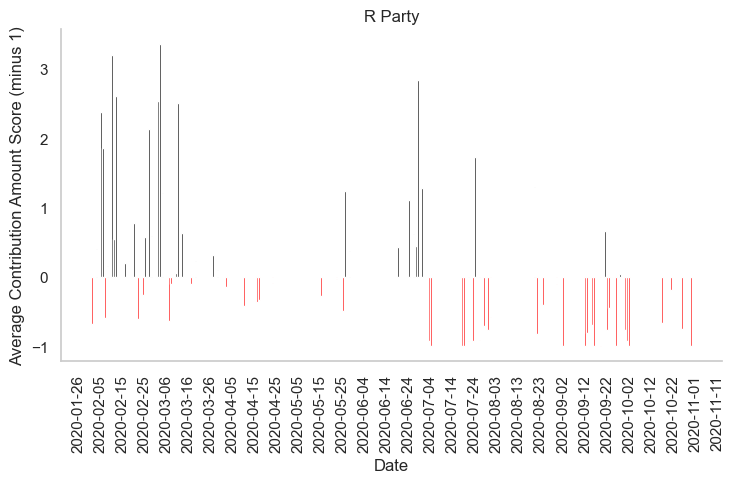

In [550]:
# Make sure dates are datetime
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])
joined_date_filter_df = joined_all_df[joined_all_df["dc_date"].between("2020-02-01","2020-11-02")]
joined_date_filter_df = joined_date_filter_df[joined_date_filter_df["dc_name"].str.contains("MCCARTHY")]

# Filter to only D and R parties
party_df = joined_date_filter_df[joined_date_filter_df["dc_party"].isin(["D", "R"])].copy()

# Subtract 1 from contrib_amount_score to center around 0
party_df["adj_contrib_score"] = party_df["contrib_amount_score"] - 1

# Group by day and party to calculate average adjusted contribution score
daily_avg_df = (
    party_df.groupby(["dc_date", "dc_party"], as_index=False)
    .agg(avg_adj_contrib_score=("adj_contrib_score", "mean"))
    .sort_values(["dc_party", "dc_date"])
)

# Create FacetGrid for party
g = sns.FacetGrid(daily_avg_df, col="dc_party", height=5, aspect=1.5)

# Plot bars manually to allow conditional coloring
def plot_colored_bars(data, **kwargs):
    ax = plt.gca()
    
    # Plot all bars with conditional coloring
    for i, row in data.iterrows():
        color = "red" if row["avg_adj_contrib_score"] < 0 else "black"
        ax.bar(row["dc_date"], row["avg_adj_contrib_score"], color=color)
    
    # Format x-axis: show labels every 10 days
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.setp(ax.get_xticklabels(), rotation=90)  # rotate labels

g.map_dataframe(plot_colored_bars)

# Set labels and remove grids
for ax in g.axes.flat:
    ax.set_xlabel("Date")
    ax.set_ylabel("Average Contribution Amount Score (minus 1)")
    ax.grid(False)

g.set_titles(col_template="{col_name} Party")
plt.tight_layout()
plt.show()

C:\Users\hefla\AppData\Local\Temp\ipykernel_19392\2376064385.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


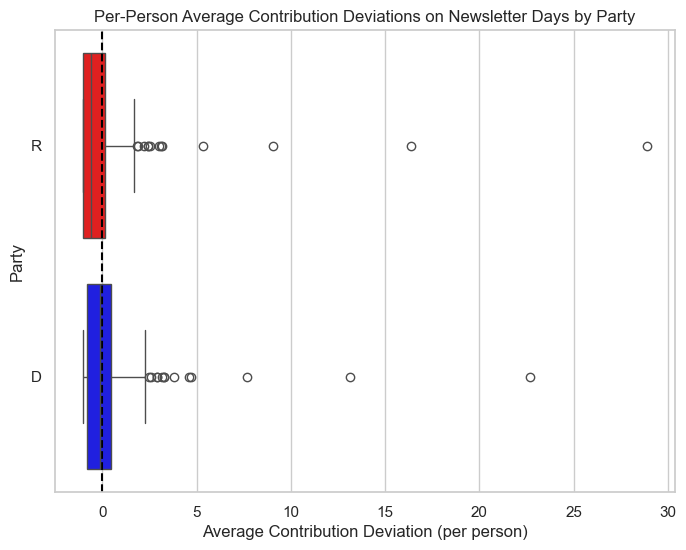

In [538]:
# Step 1: Make sure the contribution score is centered
party_df["adj_contrib_score"] = party_df["contrib_amount_score"] - 1

# Step 2: Compute per-person average deviation on newsletter days
person_avg_df = (
    party_df.groupby(["dc_name", "dc_party"], as_index=False)
    .agg(avg_adj_contrib_score=("adj_contrib_score", "mean"))
)

# Step 3: Plot horizontal boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=person_avg_df,
    y="dc_party",  # categorical variable on y-axis
    x="avg_adj_contrib_score",  # numeric variable on x-axis
    palette={"D": "blue", "R": "red"}
)
plt.axvline(0, color="black", linestyle="--")  # baseline
plt.ylabel("Party")
plt.xlabel("Average Contribution Deviation (per person)")
plt.title("Per-Person Average Contribution Deviations on Newsletter Days by Party")
plt.show()